## <font color='cornflowerblue'> Packages

In [1]:
import ta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

## <font color='cornflowerblue'> Classes and Functions

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    deposit: float
    time: str
    type: str
    is_win: bool

In [3]:
class TradingMetrics:
    def __init__(self, portfolio_values: list[float], time_frame: int):
        self.portfolio_values = portfolio_values
        self.time_frame = time_frame  # in minutes

        self.df = pd.DataFrame({
            'value': self.portfolio_values,
            'rets': pd.Series(self.portfolio_values).pct_change()
        }).dropna()

    def sharpe_ratio(self) -> float:
        mean = self.df.rets.mean()
        std = self.df.rets.std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_std = std * np.sqrt(bars_per_year)
        
        return annual_mean / annual_std

    def sortino_ratio(self) -> float:
        mean = self.df.rets.mean()
        downside_risk = np.minimum(self.df.rets, 0).std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_downside_risk = downside_risk * np.sqrt(bars_per_year)

        return annual_mean / annual_downside_risk

    def max_drawdown(self) -> float:
        roll_max = self.df.value.cummax()
        drawdown = (roll_max - self.df.value) / roll_max  # Drawdown as positive values
        return drawdown.max()  # Maximum drawdown as positive percentage

    def calmar_ratio(self) -> float:
        mean = self.df.rets.mean()
        
        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        
        max_dd = self.max_drawdown()  # Now this returns a positive value
        
        return annual_mean / max_dd if max_dd != 0 else 0

    def show_metrics(self) -> pd.DataFrame:
        df = pd.DataFrame(
            {
                'Metric': ['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio'],
                'Value': [self.sharpe_ratio(), self.sortino_ratio(), f'{self.max_drawdown():.2%}', self.calmar_ratio()]
            }
        )
        return df

In [4]:
def rsi(data: pd.DataFrame, window: int, rsi_lower: int, rsi_upper: int) -> pd.DataFrame:
    df = data.copy()
    rsi_indicator = ta.momentum.RSIIndicator(df.Close, window=window)
    df['rsi'] = rsi_indicator.rsi()
    df['buy_signal'] = df['rsi'] < rsi_lower
    df['sell_signal'] = df['rsi'] > rsi_upper
    df = df.dropna()
    return df

In [5]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float, INITIAL_MARGIN: float) -> float:
    
    val = cash 

    # Longs
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Shorts
    short_val = sum(
        pos.price * pos.n_shares * INITIAL_MARGIN + (pos.price - current_price) * pos.n_shares * (1 - COM) + pos.deposit
        for pos in short_ops
    )

    return val + short_val

## <font color='cornflowerblue'> Data

In [6]:
data = pd.read_csv('aapl_5m_train.csv').dropna()

In [7]:
data = rsi(data, window=15, rsi_lower=20, rsi_upper=80)
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
14,14,1609774800,0,2021-01-04 15:40:00,131.111297,131.309997,131.029998,131.044998,1253385.0,35.472015,False,False
15,15,1609775100,0,2021-01-04 15:45:00,131.044006,131.044006,130.479995,130.749893,1730254.0,31.779676,False,False
16,16,1609775400,0,2021-01-04 15:50:00,130.750000,130.830001,130.449996,130.709793,1887654.0,31.305254,False,False
17,17,1609775700,0,2021-01-04 15:55:00,130.700103,131.250000,130.699996,131.000000,1608419.0,38.432075,False,False
18,18,1609776000,0,2021-01-04 16:00:00,131.134994,131.309997,130.160003,130.309997,2055970.0,30.398179,False,False


## <font color='cornflowerblue'> Parameters

In [8]:
COM: float = 0.125 / 100
BORROW_RATE: float = 0.25 / 100
INITIAL_MARGIN = 1.5
MAINTENANCE_MARGIN = 1.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = BORROW_RATE / bars_per_year

# DOF
STOP_LOSS: float = 0.1
TAKE_PROFIT: float = 0.1
N_SHARES: int = 50

## <font color='cornflowerblue'> Backtest

In [9]:
initial_capital: float = 1_000_000
capital = initial_capital

winning_trades: int = 0
long_trades: int = 0
short_trades: int = 0

portfolio_value = []
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []
all_positions: list[Position] = []

#for i, row in data.iterrows():
for i, row in enumerate(data.itertuples(index=False)):

    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            pnl = (row.Close - position.price) * position.n_shares * (1 - COM)
            capital += row.Close * position.n_shares * (1 - COM)

            if pnl > 0:
                winning_trades += 1
                position.is_win = True
            # Remove position from active position
            active_long_positions.remove(position)

    equity: float = 0.0
    required_equity: float = 0.0

    # -- SHORT -- #
    for position in active_short_positions.copy():
        # Apply borrow rate to active short positions
        cover_cost = row.Close * position.n_shares
        initial_account = position.price * position.n_shares * INITIAL_MARGIN
        borrow_cost = cover_cost * bar_borrow_rate
        capital -= borrow_cost

        # Calculate equity and required equity
        equity += initial_account + position.deposit
        required_equity += MAINTENANCE_MARGIN * cover_cost

    for position in active_short_positions.copy():
        # Check Margin call
        if equity < required_equity:
            # Margin Call
            deposit = (required_equity * 1.2) - equity

            if capital > deposit:
                # Make deposit to margin account
                print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit: {deposit:.2f}')
                capital -= deposit
                equity += deposit
                position.deposit += deposit

            else:
                # We have to close the position
                print(f'Forced Close at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit Needed: {deposit:.2f} | Capital: {capital:.2f} \n')
                pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
                capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

                if pnl > 0:
                    winning_trades += 1
                    position.is_win = True

                active_short_positions.remove(position)
                continue

        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
            capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

            if pnl > 0:
                winning_trades += 1
                position.is_win = True

            active_short_positions.remove(position)
            continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           deposit=0, time=row.Datetime, type='long', is_win=False)
            active_long_positions.append(pos)
            all_positions.append(pos)
            long_trades += 1

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
        commission = row.Close * N_SHARES * COM
        cost = margin_requirement + commission

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                           deposit=0, time=row.Datetime, type='short', is_win=False)
            active_short_positions.append(pos)
            all_positions.append(pos)
            short_trades += 1

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))
    continue

# At the end of the backtesting, we should close all active positions

# Closing long positions
for position in active_long_positions:
    pnl = (row.Close - position.price) * position.n_shares * (1 - COM)
    capital += row.Close * position.n_shares * (1 - COM)

    if pnl > 0:
        winning_trades += 1
        position.is_win = True

for position in active_short_positions:
    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
    capital += pnl + position.price * N_SHARES * INITIAL_MARGIN + position.deposit

    if pnl > 0:
        winning_trades += 1
        position.is_win = True

In [10]:
capital, portfolio_value[-1], long_trades, short_trades, winning_trades

(1046412.6971409637, 1046412.6971409639, 232, 318, 308)

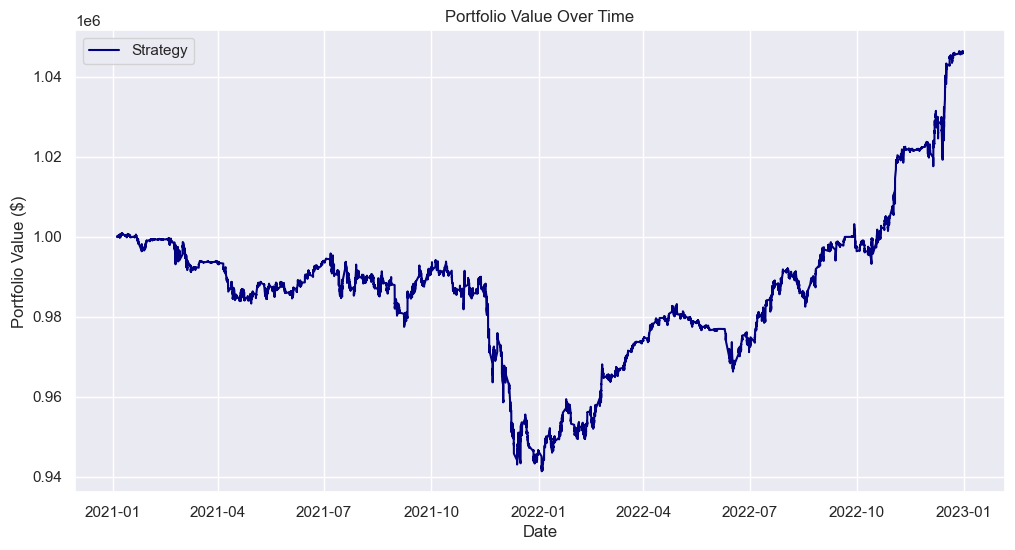

In [11]:
df = pd.DataFrame({'Portfolio Value': portfolio_value},
                  index=pd.to_datetime(data.Datetime))

rt = data.Close.pct_change()
buy_and_hold = (1 + rt).cumprod() * initial_capital

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio Value'], label='Strategy', color='navy')
#plt.plot(df.index, buy_and_hold, label='Buy and Hold', color='indianred', alpha=0.5)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

## <font color='cornflowerblue'> Metrics

In [12]:
metrics = TradingMetrics(portfolio_value, time_frame=5)
metrics.show_metrics()

,Metric,Value
0,Sharpe Ratio,0.763646
1,Sortino Ratio,1.212273
2,Max Drawdown,5.95%
3,Calmar Ratio,0.390498


In [13]:
bnh_metrics = TradingMetrics(buy_and_hold.tolist(), time_frame=5)
bnh_metrics.show_metrics()

,Metric,Value
0,Sharpe Ratio,0.138436
1,Sortino Ratio,0.213873
2,Max Drawdown,31.14%
3,Calmar Ratio,0.132263


In [14]:
def split_data(data: pd.DataFrame, train_size: float = 0.6) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the DataFrame into training and testing sets based on the given train size ratio.

    Parameters:
        data (pd.DataFrame): The DataFrame to be split.
        train_size (float): The proportion of the data to be used for training (default is 0.6).

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: A tuple containing the training, testing, and validation DataFrames.
    """

    data = data.copy()

    # Calculate split indices
    train_size = int(len(data) * train_size)
    test_size = int(len(data) * 0.2)

    # Split the data
    train = data[:train_size]
    test = data[train_size:train_size + test_size]
    validation = data[train_size + test_size:]

    return train, test, validation

In [15]:
data.set_index('Datetime', inplace=True)

In [16]:
data

,Unnamed: 0,Timestamp,Gmtoffset,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
Datetime,,,,,,,,,,,
2021-01-04 15:40:00,14,1609774800,0,131.111297,131.309997,131.029998,131.044998,1253385.0,35.472015,False,False
2021-01-04 15:45:00,15,1609775100,0,131.044006,131.044006,130.479995,130.749893,1730254.0,31.779676,False,False
2021-01-04 15:50:00,16,1609775400,0,130.750000,130.830001,130.449996,130.709793,1887654.0,31.305254,False,False
2021-01-04 15:55:00,17,1609775700,0,130.700103,131.250000,130.699996,131.000000,1608419.0,38.432075,False,False
2021-01-04 16:00:00,18,1609776000,0,131.134994,131.309997,130.160003,130.309997,2055970.0,30.398179,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 20:35:00,19787,1672432500,0,129.020004,129.050003,128.899993,129.039993,773964.0,64.733451,False,False
2022-12-30 20:40:00,19788,1672432800,0,129.029998,129.130004,128.919998,129.054992,833767.0,65.091886,False,False
2022-12-30 20:45:00,19789,1672433100,0,129.059997,129.399993,129.020004,129.380004,2136910.0,71.756380,False,False


In [17]:
train, test, validation = split_data(data, train_size=0.6)

In [18]:
train_trades = [pos for pos in all_positions if pos.time in train.index]
test_trades = [pos for pos in all_positions if pos.time in test.index]
validation_trades = [pos for pos in all_positions if pos.time in validation.index]

train_win_rate = np.mean([train_trades[i].is_win for i in range(len(train_trades))])
test_win_rate = np.mean([test_trades[i].is_win for i in range(len(test_trades))])
validation_win_rate = np.mean([validation_trades[i].is_win for i in range(len(validation_trades))])
total_win_rate = np.mean([all_positions[i].is_win for i in range(len(all_positions))])

train_win_rate, test_win_rate, validation_win_rate, total_win_rate

(0.44666666666666666, 0.6593406593406593, 0.7169811320754716, 0.56)

In [19]:
shorts = [pos for pos in all_positions if pos.type == "short"]
longs = [pos for pos in all_positions if pos.type == "long"]

In [20]:
entry_prices_long = [longs[i].price for i in range(len(active_long_positions))]
np.mean(entry_prices_long)

130.92383071428569